In [36]:
import requests
from bs4 import BeautifulSoup
import time

In [2]:
def fetch(query = None, auto_make_model = None, min_auto_year = None, max_auto_year = None, s=0):
    search_params = {key: val for key, val in locals().items() if val is not None}
    if not search_params: 
        raise ValueError("No valid keywords")
        
    base = "http://boston.craigslist.org/search/cto"
    resp = requests.get(base, params=search_params, timeout=3)
    resp.raise_for_status()
    return resp.content, resp.encoding

In [3]:
def parse(html, encoding='utf-8'):
    parsed = BeautifulSoup(html, 'lxml', from_encoding=encoding)
    return parsed

In [4]:
def extract_listings(parsed):
    listings = parsed.find_all('p', class_='result-info')
    extracted = []
    for listing in listings:
        title = listing.find('a', class_='result-title hdrlnk')
        price = listing.find('span', class_='result-price')
        try:
            price_string = price.string.strip()
        except AttributeError:
            price_string = ''
        location = listing.find('span', class_='result-hood')
        try:
            loc_string = location.string.strip()[1:-1].split()[0]
        except AttributeError:
            loc_string = ''
        this_listing = {
            'link': title.attrs['href'],
            'description': title.string.strip(),
            'price': price_string,
            'location': loc_string
        }
        extracted.append(this_listing)
    return extracted

In [5]:
import pandas as pd
import numpy as np

In [6]:
import re

def get_mileage(description):
    description = description.lower().split('k miles')
    if len(description) == 1:
        description = description[0].split('000 miles')
        if len(description) == 1:
            try:
                description = re.search('(\d{1,3})k', description[0]).groups()
            except:
                return np.nan
    mileage = re.sub('[^0-9]', '', description[0].split()[-1])
    try:
        mileage = int(mileage) * 1000
        return mileage
    except:
        return np.nan

In [16]:
def get_year(description):
    description = re.split('(20[0-9][0-9])', description)
    if len(description) == 1:
        description = re.split('(19[0-9][0-9])', description[0])
    if len(description) == 1:
        description = re.split('([0-1][0-9])', description[0])
    if len(description) == 1:
        return np.nan
    if len(description[1]) == 4: 
        year = description[1]
    elif int(description[1]) > 17: 
        year = '19' + description[1]
    else: 
        year = '20' + description[1]
    try:
        return int(year) if int(year) <= 2017 else np.nan
    except:
        return np.nan

In [24]:
def get_standard_location(location):
    """
    Use first 5 characters of location in order to group. Gets rid of much of the weird stuff
    """
    if len(location) < 5:
        return re.sub('[^a-z]', '', location.lower())
    else:
        return re.sub('[^a-z]', '', location[:5].lower())

In [9]:
def get_price(price):
    try:
        return int(price[1:]) if int(price[1:]) > 100 else np.nan
    except:
        return np.nan

In [275]:
def scrape_all(search_params={}):
    listings = []
    base = "http://boston.craigslist.org/search/cto"
    for i in range(0, 500, 100):
        search_params['s'] = i
        resp = requests.get(base, params=search_params, timeout=3)
        resp.raise_for_status()
        with open('sizing.txt', 'a+') as f:
            f.write(resp.content)
        f.close()
        car_results = resp.content, resp.encoding
        doc = parse(car_results[0])
        listings.extend(extract_listings(doc))
        time.sleep(2)
    
    df = pd.DataFrame(data=listings)
    
    df['mileage'] = df.apply(lambda row: get_mileage(row['description']), axis=1)
    df['price'] = df.apply(lambda row: get_price(row['price']), axis=1)
    df['region'] = df['link'].str[1:5]
    df['year'] = df.apply(lambda row: get_year(row['description']), axis=1)
    df['std_location'] = df.apply(lambda row: re.sub('[^a-z]', '', get_standard_location(row['location'])), axis=1)
    df.set_index('link', inplace=True)
    df = df.drop_duplicates()
    
    return df

In [108]:
all_car_info = scrape_all()
print len(all_car_info)
all_car_info = all_car_info.append(scrape_all(search_params={'searchNearby': 1}))
print len(all_car_info)
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

2407
4907
2545


In [109]:
all_car_info = all_car_info.append(scrape_all(search_params={'sort': 'pricedsc'}))
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

4718


In [110]:
all_car_info = all_car_info.append(scrape_all(search_params={'sort': 'priceasc'}))
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

6923


In [112]:
all_car_info = all_car_info.append(scrape_all(search_params={'auto_transmission': 1}))
all_car_info = all_car_info.drop_duplicates()
print len(all_car_info)

7418


In [113]:
all_car_info['std_location'] = all_car_info.apply(lambda row: re.sub('[^a-z]', '', row['std_location']), axis=1)
all_car_info.head()

,description,link,location,price,mileage,region,year,std_location
0,1996 jeep cherokee xj trade for truck,/nwb/cto/5987182859.html,Lowell,2500.0,NaN,nwb/,1996.0,lowel
1,07 volvo s40 T5 AWD,/sob/cto/6007357742.html,Taunton,7500.0,NaN,sob/,2007.0,taunt
2,2010 Subaru Forester 2.5X,/nos/cto/5988195757.html,Revere,8750.0,NaN,nos/,2010.0,rever
3,00 FORD 150 4\4 LOW MILES PLOW SET UP..,/nos/cto/5995359138.html,seabrook,1800.0,NaN,nos/,2000.0,seabr
4,2007 Chevy Cobalt,/nwb/cto/6007355695.html,Haverhill,1800.0,NaN,nwb/,2007.0,haver


In [245]:
all_car_info.set_index('link', inplace=True)
all_car_info.head()

,description,location,price,mileage,region,year,std_location
link,,,,,,,
/nwb/cto/5987182859.html,1996 jeep cherokee xj trade for truck,Lowell,2500.0,NaN,nwb/,1996.0,lowel
/sob/cto/6007357742.html,07 volvo s40 T5 AWD,Taunton,7500.0,NaN,sob/,2007.0,taunt
/nos/cto/5988195757.html,2010 Subaru Forester 2.5X,Revere,8750.0,NaN,nos/,2010.0,rever
/nos/cto/5995359138.html,00 FORD 150 4\4 LOW MILES PLOW SET UP..,seabrook,1800.0,NaN,nos/,2000.0,seabr
/nwb/cto/6007355695.html,2007 Chevy Cobalt,Haverhill,1800.0,NaN,nwb/,2007.0,haver


In [246]:
import pandas_profiling
pandas_profiling.ProfileReport(all_car_info)

Number of variables,8
Number of observations,7417
Total Missing (%),13.9%
Total size in memory,463.6 KiB
Average record size in memory,64.0 B
Numeric,3
Categorical,5
Date,0
Text (Unique),0
Rejected,0
Distinct count,6691


In [248]:
all_car_info.to_csv("all_car_info.csv", encoding='utf-8')

Methods of getting more (older) results:

-include nearby areas (searchNearby=1)

-sort by price (sort=pricedsc or sort=priceasc)

-manual transmission (auto_transmission=1)

In [249]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("ticks")

(1950, 2020.0073466988508)

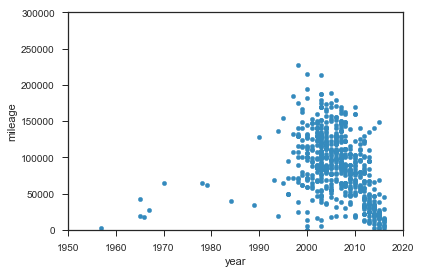

In [250]:
all_car_info.plot.scatter('year', 'mileage')
plt.ylim(0,3E5)
plt.xlim(1950,)

In [569]:
%store all_car_info

Stored 'all_car_info' (DataFrame)


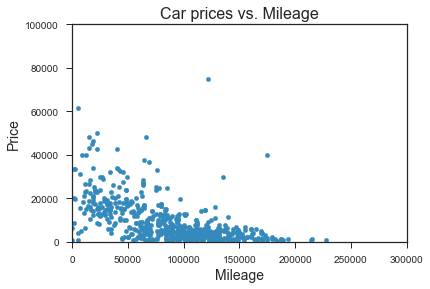

In [568]:
all_car_info.plot.scatter('mileage', 'price')
plt.xlim(0,3E5)
plt.xlabel('Mileage', fontdict={'fontsize': 14})
plt.ylim(0,1E5)
plt.ylabel('Price', fontdict={'fontsize': 14})
plt.title('Car prices vs. Mileage', fontdict={'fontsize': 16})

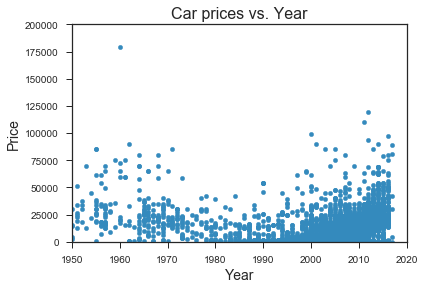

In [565]:
all_car_info.plot.scatter('year', 'price')
plt.ylim(0,2E5)
plt.ylabel('Price', fontdict={'fontsize': 14})
plt.xlim(1950,2020)
plt.xlabel('Year', fontdict={'fontsize': 14})
plt.title('Car prices vs. Year', fontdict={'fontsize': 16})

In [147]:
print all_car_info[all_car_info['price'] >= 150000]

                                       description                      link  \
854                     2015 mercedes sprinter van  /bmw/cto/6006712769.html   
0    99 Audi A4 2.8 and 02 Audi A4 1.8t for Parts!  /sob/cto/5965640273.html   
1                                           nissan  /gbs/cto/5973931006.html   
2                       Wanted International Scout  /gbs/cto/5940852470.html   
3         1936 Mercedes-Benz 540K Special Roadster  /gbs/cto/5973881754.html   
4                               Peterbilt 389 v100  /gbs/cto/5967894374.html   
6            2013 Toyota Tacoma Trd sport crew cab  /gbs/cto/5974877040.html   
7                         1960 Mercedes Benz 190SL  /gbs/cto/5964635170.html   

      location       price   mileage region    year std_location  
854    Norfolk    320000.0       NaN   bmw/  2015.0        norfo  
0       Quincy  20002500.0       NaN   sob/  2002.0        quinc  
1                3434535.0       NaN   gbs/     NaN               
2     Anywh

In [ ]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Year')
ax1.set_ylabel('Price($)')
ax1.set_title('Price vs Mileage and Year for Used Honda Civics, 2000-2016', y= 1.2)
plt.plot(df['year'], df['price'], '.', ms=10, label='year')
ax1.set_xbound(lower=1999, upper=2017)
ax1.legend(loc='best')
ax2 = ax1.twiny()
ax2.set_xlabel('Mileage')
plt.plot(df['mileage'], df['price'], 'g*', ms=10, label='mileage')
ax2.legend(loc=2)
plt.tight_layout()
plt.savefig('price_year_mileage.pdf')

In [ ]:
plt.plot(df['price'], df['mileage'], linestyle='', marker='.')

In [263]:
regions = all_car_info[all_car_info['std_location'] != ''].groupby('std_location').agg(['mean', 'count'])

In [264]:
regions = regions[regions['price','count'] >= 50]
regions = regions[regions['mileage','count'] >= 5]

In [265]:
regions.head()

price              mileage               year      
                      mean count           mean count         mean count
std_location                                                            
abing          5309.057143    70  107571.428571     7  2004.161765    68
arlin          7930.518519    54   96000.000000    13  2007.745098    51
bosto         10769.115079   252   71900.000000    10  2001.287081   209
evere         10429.645161    62   52750.000000     8  2006.566667    60
lowel          8242.751825   137  112100.000000    20  2001.674603   126

In [570]:
%store regions

Stored 'regions' (DataFrame)


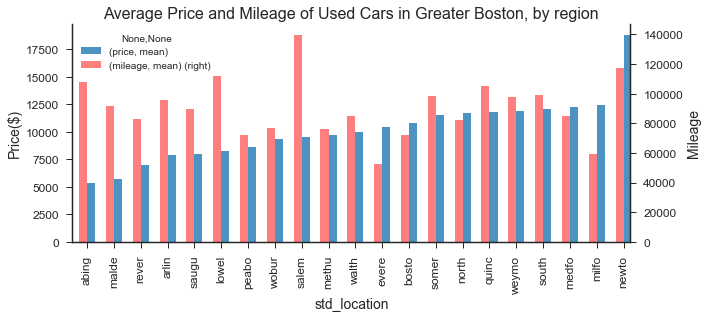

In [549]:
regions.sort_values(by=[('price', 'mean')], inplace=True)
ax = regions['price','mean'].plot.bar(position=0, width=0.3, alpha=0.8, legend=True)
ax.set_title('Average Price and Mileage of Used Cars in Greater Boston, by region', fontdict={'fontsize':16})
ax.set_xlabel('City/Town', fontdict={'fontsize':14})
ax.set_xticklabels(regions.index, fontdict={'fontsize':12})
ax.set_ylabel('Price($)', fontdict={'fontsize':14})
ax.set_yticklabels(range(0,20000,2500), fontdict={'fontsize':12})
ax = regions['mileage','mean'].plot.bar(secondary_y=True, color='red', position=1, width=0.3, alpha=0.5, legend=True)
ax.set_ylabel('Mileage', fontdict={'fontsize':14})
ax.set_yticklabels(range(0,160000,20000), fontdict={'fontsize':12})
sns.despine(top=True, right=False)
fig=ax.get_figure()
fig.set_size_inches(10,4)
fig.savefig('price_mileage_region.pdf', bbox_inches='tight')

In [ ]:
from scipy.stats import linregress

In [ ]:
print linregress(df['mileage'][~df['price'].isnull()].dropna(), df['price'][~df['mileage'].isnull()].dropna())
print linregress(df['year'][~df['price'].isnull()].dropna(), df['price'][~df['year'].isnull()].dropna())
print linregress(df['year'][~df['mileage'].isnull()].dropna(), df['mileage'][~df['year'].isnull()].dropna())

In [ ]:
def draw_regional_fig(make, model, year):
    listings = []
    make_model = "{0} {1}".format(make,model)
    min_auto_year = int(year) - 2
    max_auto_year = int(year) + 2
    if max_auto_year > 2016:
        max_auto_year = 2016
    for i in range(0, 500, 100):
        car_results = fetch(auto_make_model=make_model, min_auto_year=min_auto_year, max_auto_year=max_auto_year, s=i)
        doc = parse(car_results[0])
        listings.extend(extract_listings(doc))
    
    df = pd.DataFrame(data=listings)
    if len(df) == 0: return "No results found, check your spelling"
    df['mileage'] = df.apply(lambda row: get_mileage(row['description']), axis=1)
    df['price'] = df.apply(lambda row: get_price(row['price']), axis=1)
    df['region'] = df['link'].str[1:5]
    df['year'] = df.apply(lambda row: get_year(row['description']), axis=1)
    
    regions = df.groupby('region').mean()
    regions = regions.append(pd.Series(data={'year': np.mean(df['year']), 'price': np.mean(df['price']), 'mileage': np.mean(df['mileage'])}, name='AVERAGE'))
    
    my_title = 'Average Price and Mileage of Used {0} {1}, {2}-{3}, by region, n={4}'.format(make, model, min_auto_year, max_auto_year, len(df))
    ax = regions['price'].plot.bar(position=0, width=0.3, alpha=0.5, legend=True, title=my_title)
    ax.set_ylabel('Price($)')
    ax = regions['mileage'].plot.bar(secondary_y=True, color='green', position=1, width=0.3, alpha=0.5, legend=True)
    ax.set_ylabel('Mileage')
    sns.despine(top=True, right=False)
    fig=ax.get_figure()
    
    return fig

In [286]:
focus_data = scrape_all(search_params={'auto_make_model': 'ford focus'})
print len(focus_data)
focus_data = focus_data.append(scrape_all(search_params={'auto_make_model': 'ford focus', 'searchNearby': 1}))
print len(focus_data)
focus_data = focus_data.drop_duplicates()
print len(focus_data)

144
288
144


In [287]:
focus_data = focus_data.append(scrape_all(search_params={'auto_make_model': 'ford focus', 'sort': 'priceasc'}))
print len(focus_data)
focus_data = focus_data.drop_duplicates()
print len(focus_data)

287
144


In [288]:
focus_data = focus_data.append(scrape_all(search_params={'auto_make_model': 'ford focus', 'sort': 'pricedsc'}))
print len(focus_data)
focus_data = focus_data.drop_duplicates()
print len(focus_data)

287
144


In [289]:
focus_data = focus_data.append(scrape_all(search_params={'auto_make_model': 'ford focus', 'auto_transmission': 1}))
print len(focus_data)
focus_data = focus_data.drop_duplicates()
print len(focus_data)

205
177


In [290]:
focus_data

,description,location,price,mileage,region,year,std_location
link,,,,,,,
/bmw/cto/5987989600.html,2010 FORD FOCUS SE ONE OWNER CLEAN CARFAX DEAL...,MILFORD,5495.0,NaN,bmw/,2010.0,milfo
/sob/cto/6001827529.html,2001 Ford Focus Sedan for parts or repair,South,600.0,NaN,sob/,2001.0,south
/bmw/cto/5985525152.html,2002 Ford Focus,Northborough,850.0,NaN,bmw/,2002.0,north
/bmw/cto/5994647265.html,"2007 Ford Focus, 91,000 miles","Miford,",4495.0,91000.0,bmw/,2007.0,mifor
/gbs/cto/5975605800.html,2012 FORD FOCUS SEDAN SE,HUDSON,5600.0,NaN,gbs/,2012.0,hudso
/gbs/cto/5983824912.html,2003 ford focus wagon for sale,newton,2000.0,NaN,gbs/,2003.0,newto
/nos/cto/5970360302.html,2007 Ford Focus SE,SWAMPSCOTT,2900.0,NaN,nos/,2007.0,swamp
/gbs/cto/6010724770.html,2007 Ford Focus $600,,600.0,NaN,gbs/,2007.0,
/gbs/cto/6010741337.html,2004 Ford Focus Se,,1500.0,NaN,gbs/,2004.0,


In [291]:
focus_years = focus_data.groupby('year').agg(['mean', 'count'])
focus_years

price              mileage      
                mean count           mean count
year                                           
2000.0   1767.857143     7   60500.000000     2
2001.0   1355.384615    13   90000.000000     1
2002.0   1491.611111    18   84666.666667     3
2003.0   1670.312500    16  114333.333333     6
2004.0   1849.166667     6  128000.000000     1
2005.0   1951.791667    24  102285.714286     7
2006.0   3043.900000    10   97000.000000     2
2007.0   2970.875000    16   80500.000000     2
2008.0   4112.714286     7            NaN     0
2009.0   4665.833333     6   64000.000000     2
2010.0   4177.714286     7   94000.000000     1
2011.0   7432.666667     3            NaN     0
2012.0   6938.200000    10   77250.000000     4
2013.0   7798.333333     6   43000.000000     1
2014.0  15665.666667     6            NaN     0
2015.0  10105.833333     6   26500.000000     2
2016.0    970.000000     2            NaN     0

In [293]:
focus_data[focus_data['year']==2016]

,description,location,price,mileage,region,year,std_location
link,,,,,,,
/gbs/cto/5999533717.html,2016 Ford Focus hatchback lease takeover,Wakefield,290.0,NaN,gbs/,2016.0,wakef
//worcester.craigslist.org/cto/5983547331.html,Ford Focus ZX3 - 5 Speed -= 30+ mpg $$ 1650,,1650.0,NaN,/wor,2016.0,


In [432]:
%store -r ford_focus_years

In [433]:
focus_years = focus_years.join(ford_focus_years)
focus_years

/Users/belinda/anaconda2/lib/python2.7/site-packages/pandas/tools/merge.py:536: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(price, mean)","(price, count)","(mileage, mean)","(mileage, count)",id,styles,typical_data,used_private_party,used_tradein,used_tmv_retail,certified
year,,,,,,,,,,,
2000.0,1767.857143,7,60500.000000,2,1131,"{u'styles': [{u'trim': u'SE', u'name': u'SE 4d...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,884.0,292.0,1875.0,0.0
2001.0,1355.384615,13,90000.000000,1,100000083,"{u'styles': [{u'trim': u'ZX3', u'name': u'ZX3 ...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,929.0,301.0,1978.0,0.0
2002.0,1491.611111,18,84666.666667,3,100000084,"{u'styles': [{u'trim': u'ZX3 Premium', u'name'...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1009.0,415.0,1998.0,0.0
2003.0,1670.312500,16,114333.333333,6,100502787,"{u'styles': [{u'trim': u'SE Comfort', u'name':...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1146.0,510.0,2210.0,0.0
2004.0,1849.166667,6,128000.000000,1,100503532,"{u'styles': [{u'trim': u'ZX3 Comfort', u'name'...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1117.0,489.0,2162.0,0.0
2005.0,1951.791667,24,102285.714286,7,100504602,"{u'styles': [{u'trim': u'ZX4 ST', u'name': u'Z...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1548.0,813.0,2779.0,0.0
2006.0,3043.900000,10,97000.000000,2,100506349,"{u'styles': [{u'trim': u'ZX4 ST', u'name': u'Z...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1612.0,760.0,3034.0,0.0
2007.0,2970.875000,16,80500.000000,2,100512839,"{u'styles': [{u'trim': u'ZX5 SE', u'name': u'Z...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,1893.0,978.0,3405.0,0.0
2008.0,4112.714286,7,NaN,0,100512964,"{u'styles': [{u'trim': u'S', u'name': u'S 2dr ...",{u'tmv': {u'colorAdjustment': {u'usedPrivatePa...,2544.0,1395.0,4123.0,0.0


In [574]:
%store focus_years

Stored 'focus_years' (DataFrame)


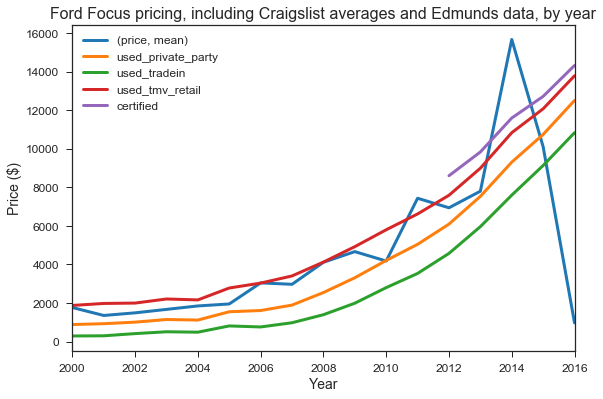

In [522]:
%matplotlib inline
focus_years = focus_years.replace(0, np.nan)
ax = focus_years.plot(y=[('price', 'mean'), 'used_private_party', 'used_tradein', 'used_tmv_retail', 'certified'], lw=3)
ax.set_ylabel("Price ($)", fontdict={'fontsize': 14})
ax.set_yticklabels(range(-2000,18000, 2000), fontdict={'fontsize': 12})
ax.set_xlabel("Year", fontdict={'fontsize': 14})
ax.set_xticklabels(range(2000,2018,2), fontdict={'fontsize': 12})
ax.set_title("Ford Focus pricing, including Craigslist averages and Edmunds data, by year", fontdict={'fontsize': 16})
ax.legend(fontsize = 'large')
fig=ax.get_figure()
fig.set_size_inches(9,6)
fig.savefig('compare_prices.pdf', bbox_inches='tight')

In [457]:
focus_data[focus_data['year']==2016]

,description,location,price,mileage,region,year,std_location
link,,,,,,,
/gbs/cto/5999533717.html,2016 Ford Focus hatchback lease takeover,Wakefield,290.0,NaN,gbs/,2016.0,wakef
//worcester.craigslist.org/cto/5983547331.html,Ford Focus ZX3 - 5 Speed -= 30+ mpg $$ 1650,,1650.0,NaN,/wor,2016.0,


In [459]:
focus_data[focus_data['year']==2014]

,description,location,price,mileage,region,year,std_location
link,,,,,,,
/nos/cto/5998874532.html,2014 Ford Focus Sedan SE sports package,Billerica,13000.0,NaN,nos/,2014.0,bille
/bmw/cto/6000996919.html,2014 Ford Focus SE Sedan,Arlington,11995.0,NaN,bmw/,2014.0,arlin
/nwb/cto/5951866403.html,2014 Ford Focus SE Silver - 1 Owner - Like New,Tewksbury,14000.0,NaN,nwb/,2014.0,tewks
/bmw/cto/5986928247.html,2014 Ford Focus ST,Lunenburg,20000.0,NaN,bmw/,2014.0,lunen
/gbs/cto/5975159514.html,2014 Ford Focus se,,NaN,NaN,gbs/,2014.0,
/bmw/cto/5981878527.html,2014 Ford Focus ST ST3,,18000.0,NaN,bmw/,2014.0,
//southcoast.craigslist.org/cto/5969313945.html,2014 Ford Focus ST,,16999.0,NaN,/sou,2014.0,


In [575]:
%store focus_data

Stored 'focus_data' (DataFrame)


In [356]:
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import ShuffleSplit, train_test_split

In [383]:
data = all_car_info[['year', 'mileage', 'price']].dropna()
data = data[data['price'] < 100000]
data = data[data['mileage'] < 500000]
data = data[data['year'] > 1986]
X = data[['year', 'mileage']]
y = data['price']

In [398]:
coeff = []
scores = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    coeff.append(model.coef_)
    scores.append(model.score(X_test,y_test))
print "Average score = {0} +/- {1}".format(round(np.mean(scores),3), round(np.std(scores),3))

Average score = 0.401 +/- 0.076


In [573]:
%store X_test
%store y_test
%store model
%store scores

Stored 'X_test' (DataFrame)
Stored 'y_test' (Series)
Stored 'model' (LinearRegression)
Stored 'scores' (list)


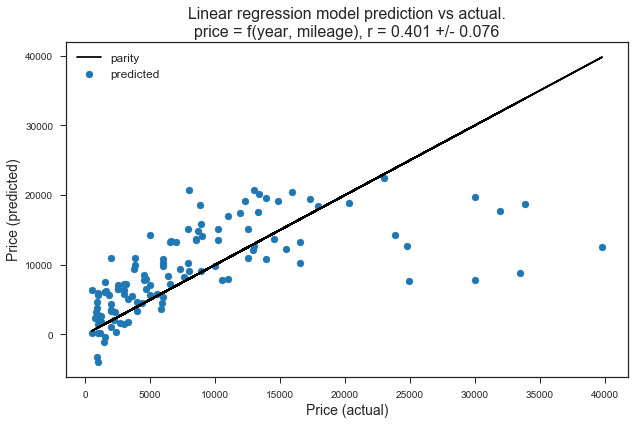

In [527]:
fig = plt.figure(figsize=(9,6))
plt.scatter(y_test, model.predict(X_test), label="predicted")
plt.plot(y_test, y_test, color='black', label="parity")
plt.title("Linear regression model prediction vs actual.\nprice = f(year, mileage), r = {0} +/- {1}".format(
    round(np.mean(scores),3), round(np.std(scores),3)), fontdict={'fontsize': 16})
plt.xlabel("Price (actual)", fontdict={'fontsize': 14})
plt.ylabel("Price (predicted)", fontdict={'fontsize': 14})
plt.legend(loc='best', fontsize='large')
plt.tight_layout()
fig.savefig('regression.pdf')

In [402]:
print model.coef_

[  7.51111069e+02  -7.83641712e-02]
